In [188]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
# %matplotlib inline  # if you are running this code in Jupyter notebook

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from skimage import data, transform, util
from sklearn.linear_model import LinearRegression

In [3]:
vidcap = cv2.VideoCapture('data/video.MOV')
success,image = vidcap.read()
count = 0
while success:
    cv2.imwrite(f"frame{count}.jpg", image)     # save frame as JPEG file      
    success,image = vidcap.read()
    print('Read a new frame: ', success)
    count += 1
    break

In [4]:
input_images = []
for i in range(1, 10):
    img = cv2.imread(f'data/{i}.PNG')
    input_images.append(img)

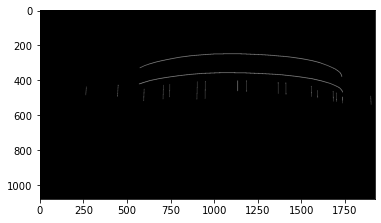

In [5]:
img_source_mask = cv2.imread('frame0-mask.png')
green_mask = (img_source_mask[:, :, 1] > 240) & (img_source_mask[:, :, 0] < 10)
img_source_mask[(1 - green_mask).astype(bool)] = 0
img_source_mask[green_mask] = 255
img_source_mask = cv2.cvtColor(img_source_mask, cv2.COLOR_BGR2GRAY)#img_source_mask.mean(axis=2)
plt.imshow(img_source_mask, cmap='gray')

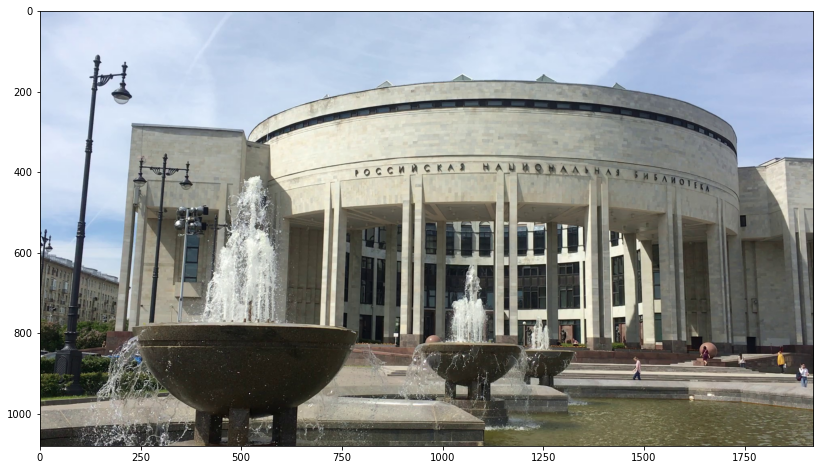

In [222]:
points_list = [
    [(260, 310), (460, 320), (458, 400), (255, 390)],  # width, height
    [(600, 320), (710, 290), (710, 385), (600, 405)],
    [(750, 280), (900, 260), (900, 360), (750, 375)],
    [(950, 255), (1130, 250), (1130, 355), (950, 360)],
    [(1190, 255), (1360, 265), (1360, 370), (1190, 360)],
    [(1410, 270), (1550, 290), (1550, 390), (1410, 370)],
    [(1590, 300), (1670, 330), (1670, 410), (1590, 390)],
]

img_source = cv2.imread('frame0.jpg')
img_work = img_source.copy()

# cv2.polylines(img_source, np.array(points_list), True, (0, 0, 255), 5)
_, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.imshow(cv2.cvtColor(img_source, cv2.COLOR_RGB2BGR))

## Поиск кривых по маске

In [7]:
def imshow(*args):
    img_len = len(args)
    fig, axes = plt.subplots(1, img_len, figsize=(16, 8))
    
    if not isinstance(axes, list):
        axes = [axes]
    for ax, img in zip(axes, args):
        ax.imshow(img)
    
    plt.show()

In [214]:
threshold = 100

lines = []  # (border [left, right], line)

def approximate_lines(lines):
    lines_out = []
    for line_info in lines:
        line = np.array(line_info['line'])
        
        m = LinearRegression().fit(line[:, 0].reshape((line.shape[0], 1)), line[:, 1])
        rows = np.arange(1, line[:, 0].max())
        cols = m.predict(rows.reshape((rows.shape[0], 1)))
        
        lines_out.append(np.vstack((rows, cols)).T)

    return lines_out

def add_points_to_lines(lines, points: list, row, shift=1):
    for p in points:
        lines_filtered = list(filter(lambda l: l['border'][0] <= p <= l['border'][1], lines))

        if not lines_filtered:
            lines.append({'border': (p - shift, p + shift), 'line': [(row, p)]})
        else:
            if len(lines_filtered) > 1:  # дошли до дуги
                lines_filtered = sorted(lines_filtered, key=lambda l: -len(l['line']))
            
            line_info = lines_filtered[0]
            if line_info['line'][-1][0] - row < 2:
                line_info['line'].append((row, p))

                border = line_info['border']
                line_info['border'] = (min(p - shift, border[0]), max(p + shift, border[1]))  # обновить границы
    
    return lines

for i, row in enumerate(range(img_source_mask.shape[0] - 1, 0, -1)):
    img_row = img_source_mask[row, :]
    indices = np.where(img_row > threshold)[0]
    if indices.shape[0] > 1:
        diff, splits = np.diff(indices), []
        if (diff > 5).any():
            split_indices = np.where(diff > 5)[0] + 1
            splits = np.split(indices, split_indices)
        else:
            splits = [indices]
        
        splits = list(map(lambda v: int(v.mean()), splits))
        
        lines = add_points_to_lines(lines, splits, row)

lines = list(filter(lambda l: len(l['line']) > 10, lines))
lines = list(filter(lambda l: abs(l['line'][0][1] - l['line'][-1][1]) / len(l['line']) < 0.2, lines))
len(lines)

17

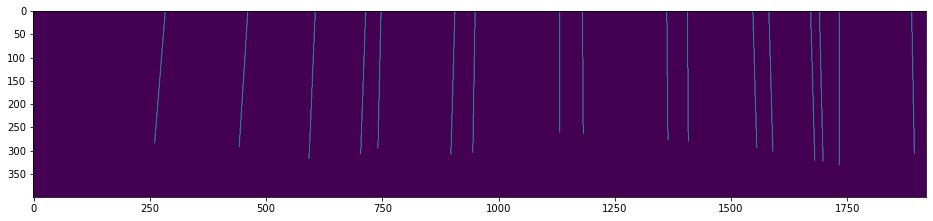

In [220]:
tmp = np.zeros(img_source_mask.shape, dtype='uint8')
for i, line in enumerate(approximate_lines(lines)):
#     if i != 19: continue
#     if len(line['line']) > 1:
    for point in line:
        tmp[int(point[0]), int(point[1])] = 255
imshow(tmp[200:600, : ])

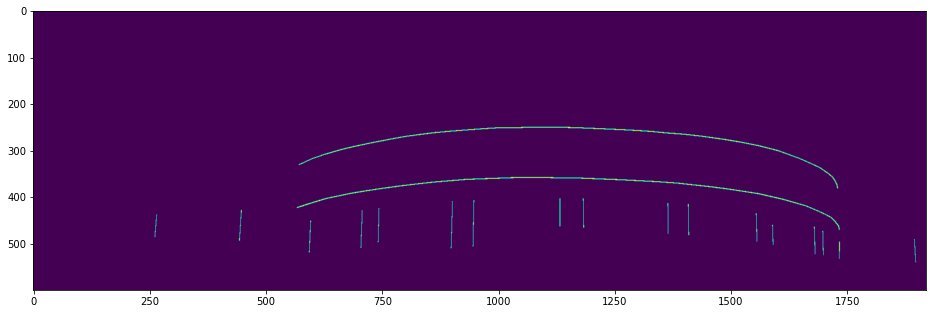

In [89]:
imshow(img_source_mask[:600, :])

In [60]:
def find_next_index(img, start, threshold_color=100, threshold_diff=40):
    c_upp, c_down = None, None  # curve
    for col in range(start, img.shape[1]):
        white_points = np.where(img[:, col] > threshold_color)[0]
        
        if white_points.shape[0] > 0:
            return (white_points[-1], col)

    return None

def determine_curve(img, start_point):
    curve = [start_point]
    not_found = True
    while not_found:
        last_point = curve[-1]
        next_col = last_point[1] + 1
        next_rows = np.arange(last_point[0] - 1, last_point[0] + 2)

        colors = img[next_rows, next_col]
        not_found = (colors > 100).any()
        if not_found:
            curve.append((int(next_rows[colors > 100].mean()), next_col))

    return curve

def go_by_direction(img, straight: list, direction: str, threshold=100):
    direction = -1 if direction == 'up' else 1
    
    not_found = True
    while not_found:
        last_point = straight[-1]
        
        next_row = last_point[0] + direction
        next_cols = np.arange(last_point[1] - 1, last_point[0] + 2)

        colors = img[next_row, next_cols]
        not_found = (colors > threshold).any()
        if not_found:
            straight.append((next_row, int(next_cols[colors > threshold].mean())))
    
    return straight
    

def determine_straight(img, start_point, threshold=100):
    """
    return: Взвращает прямую от нижней точки к верхней
    """
    straight = list(reversed(go_by_direction(img, [start_point], 'down')))
    print(straight)
    straight = go_by_direction(img, straight, 'up', threshold=threshold)
    return straight

def find_curves(img_mask):
    """
    returned: absolute coordinates
    """
    
    curves = {'top': None, 'bottom': None}
    straights = []  # vertical lines
    
    indices = np.where(img_mask > 100)
    h_min, h_max = indices[0].min() - 1, indices[0].max()
    w_min, w_max = indices[1].min(), indices[1].max()
    
    # Взять только тот кусок изображения, где есть хоть один выделенный (зеленый) пиксель
    img_path = img_mask[h_min: h_max, w_min: w_max]
    
    col = 0
    while col < img_path.shape[1]:
        next_pos = find_next_index(img, start=col, threshold_color=100, threshold_diff=40)
        if next_pos is None:
            break
        
#         next_row, next_col = next_pos
        line = np.array(determine_curve(img_mask, next_pos))
        print(line)
        if len(line) > 100:
            curves['top' if curves['top'] is None else 'bottom'] = line
        else:
            line = np.array(determine_straight(img_mask, next_pos))
            straights.append(line)
        
        col = line[:, 1].max() + 5

    c_upp, c_down = find_first_indices(img_path)
    curve_upp = determine_curve(img_path, c_upp)
    curve_down = determine_curve(img_path, c_down)
    
    shift = np.array([h_min, w_min])

    return {'top': np.array(curve_upp) + shift, 'bottom': np.array(curve_down) + shift}  # row, col

In [61]:
curves = find_curves(img_source_mask)

[[485 261]
 [484 262]]
[(493, 443), (492, 443), (491, 443), (490, 443), (489, 443), (488, 443), (487, 444), (486, 444), (485, 261)]
[[ 422  567]
 [ 422  568]
 [ 421  569]
 ...
 [ 451 1724]
 [ 452 1725]
 [ 453 1726]]
(82, 310) (172, 310)


## Вставка изображения

In [480]:
def cut_out_pixels(mask, figure_shape):
    poly_coords = list(map(lambda v: tuple(v), figure_shape))
    poly_coords[0] = (poly_coords[0][0] + 1, poly_coords[0][1] + 1)  # width, height
    poly_coords[1] = (poly_coords[1][0] - 1, poly_coords[1][1] + 1)
    poly_coords[2] = (poly_coords[2][0] - 1, poly_coords[2][1] - 1)
    poly_coords[3] = (poly_coords[3][0] + 1, poly_coords[3][1] - 1)
    polygon = Polygon(poly_coords)
    
    for i in range(mask.shape[0]):  # rows
        for j in range(mask.shape[1]):  # cols
            if mask[i, j]:
                p = Point(j, i)
                mask[i, j] = polygon.contains(p)
    
    return mask

def paste_img(img_source, curves, dst, frame, frame_transformed):
    """
    param frame: top, right, bottom, left
    """
    mask = dst.mean(axis=2) > 0
#     print(frame_transformed)
    mask = cut_out_pixels(mask, frame_transformed)
#     plt.imshow(mask)

    top, right, bottom, left = frame
    img_piece = img_source[top: bottom, left: right, :]
    img_piece[mask] = dst[mask]
 
    img_source[top: bottom, left: right, :] = img_piece
    return img_source

## Вставка изображения в библиотеку

In [645]:
def calc_mask(pic, curve_top, curve_bottom):
#     plt.imshow(pic)
#     mask = np.ones((pic.shape[0], pic.shape[1])).astype(bool)
    mask = ~(pic == [0, 0, 0])
    
#     grid_row, _ = np.mgrid[0: pic.shape[0], 0: pic.shape[1]]
#     mask[(grid_row < curve_top[:, 0]) | (grid_row > curve_bottom[:, 0])] = False
    
#     print((pic == [0, 0, 0]).min(axis=2).mean(axis=1))
#     mask[(pic == [0, 0, 0]).min(axis=2).mean(axis=1) > 0.3, :] = False
    
    return mask
    
    
def affine_transform(pic, curve_top, curve_bottom):
    height, width, _ = pic.shape
    cols = np.repeat(np.arange(width), 2)
    
    shift = np.abs(curve_top[:, 0]).max()
    pic_copy = np.zeros((height + shift, width, 3))
    pic_copy[shift:] = pic

    dst_rows = np.vstack((curve_top[:, 0] + shift, curve_bottom[:, 0] + shift))
    dst = np.vstack((cols, dst_rows.T.flat)).T
    
    src_rows = np.vstack((np.zeros(width) + shift, np.full(width, fill_value=height) + shift))
    src = np.vstack((cols, src_rows.T.flat)).T  # col, row
    
    tform = transform.PiecewiseAffineTransform()
    tform.estimate(src, dst)
    
    out_rows, out_cols, _ = pic.shape
    out = transform.warp(pic_copy, tform.inverse,
                         order=1,
                         clip=True,
                         mode='constant',
                         cval=0)
#     plt.imshow(out)

    return util.img_as_ubyte(out), shift

def insert_pic(img, pic, border: tuple, curves: dict):
    """
    param border: tuple(left, right), left pixel and right pixel
    """
    left, right = border
    top_curve, bottom_curve = curves['top'], curves['bottom']
    lt = (left, top_curve[top_curve[:, 1] == left][0][0])  # Берем строку
    lb = (left, bottom_curve[bottom_curve[:, 1] == left][0][0])

    rt = (right, top_curve[top_curve[:, 1] == right][0][0])
    rb = (right, bottom_curve[bottom_curve[:, 1] == right][0][0])
    
    pic_resized = transform.resize(pic, (lb[1] - lt[1], right - left), anti_aliasing=True)
    
    pic_curve_top = top_curve[(top_curve[:, 1] >= left) * (top_curve[:, 1] < right)]
    pic_curve_top[:, 0] -= lt[1]
    pic_curve_bottom = bottom_curve[(bottom_curve[:, 1] >= left) * (bottom_curve[:, 1] < right)]
    pic_curve_bottom[:, 0] -= lt[1]
    
    pic_transformed, shift = affine_transform(pic_resized, pic_curve_top, pic_curve_bottom)
#     fig, axes = plt.subplots(1, 2, figsize=(16, 8))
#     axes[0].imshow(pic_resized)
#     axes[1].imshow(pic_transformed)

    img_path = img[lt[1] - shift: lb[1], left: right, :]

    mask = calc_mask(pic_transformed, pic_curve_top + shift, pic_curve_bottom + shift)
    img_path[mask] = pic_transformed[mask]
    img[lt[1] - shift: lb[1], left: right, :] = img_path
    
    return img

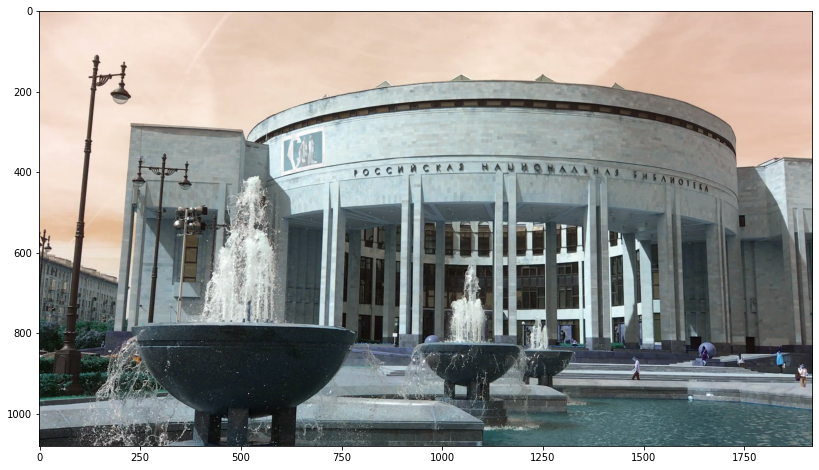

In [648]:
img_work = img_source.copy()

left, right = points_list[1][0][0], points_list[1][1][0]
curves = find_curves(img_source_mask)

dst = insert_pic(img_work, input_images[1], border=(left, right), curves=curves)

_, ax = plt.subplots(1, 1, figsize=(14, 8))
plt.imsave('out.png', dst)
ax.imshow(dst)

In [653]:
curves = find_curves(img_source_mask)

img_work = img_source.copy()

for i, (points, pic) in enumerate(zip(points_list, input_images[:7])):
    if i == 0: continue
    left, right = points[0][0], points[1][0]
    img_work = insert_pic(img_work, pic, border=(left, right), curves=curves)
    # Деформировать для первого и последнего изображения не надо
#     dst, paste_border = transform(pic, np.array(points), curves, to_warp=i in {0, 8})
#     points_shifted = points - np.array([paste_border[-1], paste_border[0]])
    
#     img_work = paste_img(img_work, curves, dst, paste_border, frame_transformed=points_shifted)
#     break

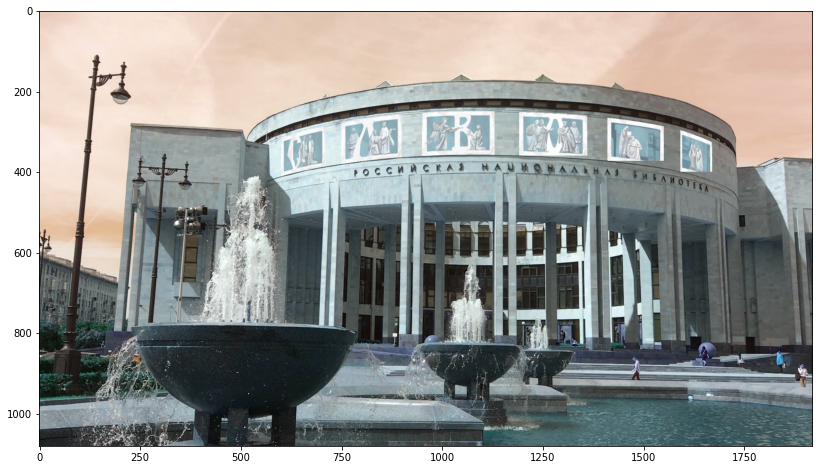

In [654]:
_, ax = plt.subplots(1, 1, figsize=(14, 8))
ax.imshow(img_work)
plt.imsave('out.png', img_work)

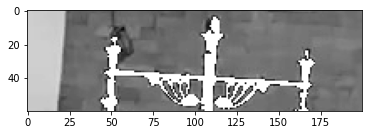

In [199]:
gray = cv2.cvtColor(img_source[350: 410, 200: 400], cv2.COLOR_BGR2GRAY)
gray[:, :][gray[:, :] < 90] = 255

plt.imshow(gray, cmap='gray')